/host/bb-comp/tank/data/BIDS_PNI/derivatives/hippunfold_v2.0.0/sub-PNC010/ses-01/metric/sub-PNC010_ses-01_hemi-L_den-8k_label-dentate_*subfields*.label.gii failed (no matches)
/host/bb-comp/tank/data/BIDS_PNI/derivatives/hippunfold_v2.0.0/sub-PNC010/ses-01/metric/sub-PNC010_ses-01_hemi-R_den-8k_label-dentate_*subfields*.label.gii failed (no matches)


/host/cassio/export03/data/opt/miniconda3/envs/hippunfold-dev/lib/python3.12/site-packages/brainspace/plotting/base.py:287: UserWarning: Interactive mode requires 'panel'. Setting 'interactive=False'
  warnings.warn("Interactive mode requires 'panel'. "


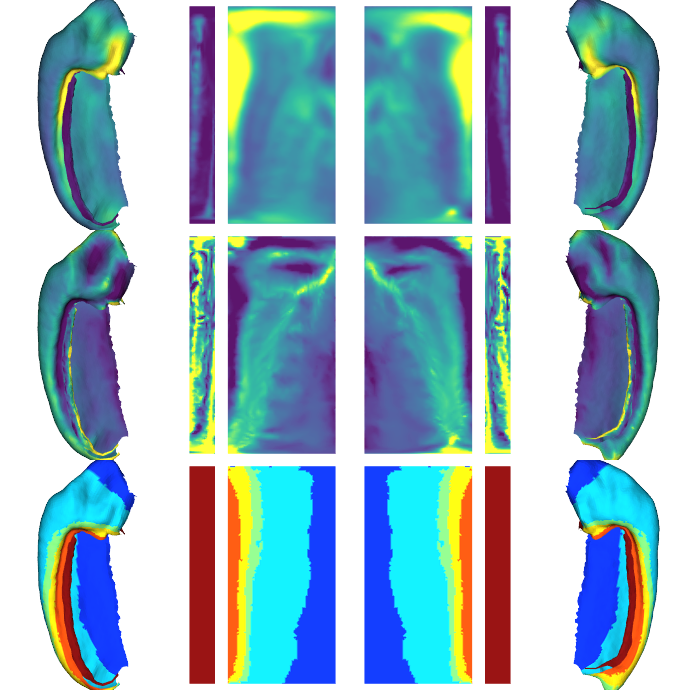

In [1]:
import hippomaps as hm
hm.plotting.surfplot_sub_foldunfold("/host/bb-comp/tank/data/BIDS_PNI/derivatives/hippunfold_v2.0.0/", "PNC010", "01", ["thickness", "curvature", "subfields"], den="8k", embed_nb=True)

/export03/data/tmp/ipykernel_3984045/2019272448.py:64: UserWarning: Missing metric (skipping): /host/bb-comp/tank/data/BIDS_PNI/derivatives/hippunfold_v2.0.0/sub-PNC010/ses-01/metric/sub-PNC010_ses-01_hemi-L_den-8k_label-dentate_*subfields*.label.gii
  warnings.warn(f"Missing metric (skipping): {pat}")
/export03/data/tmp/ipykernel_3984045/2019272448.py:64: UserWarning: Missing metric (skipping): /host/bb-comp/tank/data/BIDS_PNI/derivatives/hippunfold_v2.0.0/sub-PNC010/ses-01/metric/sub-PNC010_ses-01_hemi-R_den-8k_label-dentate_*subfields*.label.gii
  warnings.warn(f"Missing metric (skipping): {pat}")


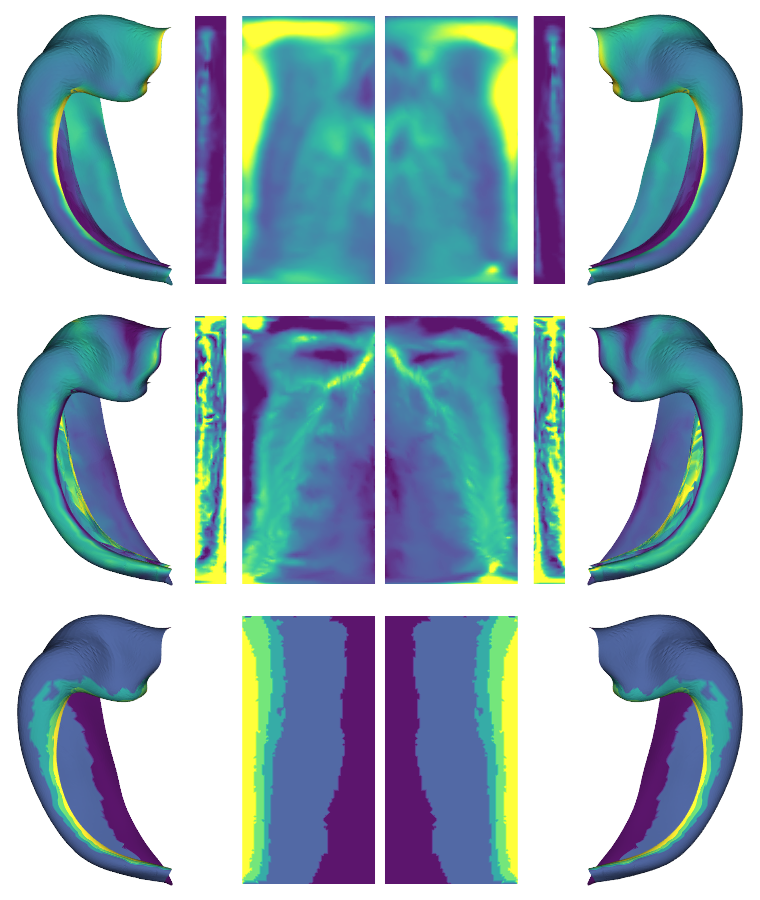

In [2]:
import numpy as np
import nibabel as nib
import glob
import warnings
from pathlib import Path
from scipy.spatial import cKDTree
from nibabel.nifti1 import intent_codes

import hippomaps.plotting as hm  # your plotting.py module

# ----------------------------
# Inputs
# ----------------------------
hippunfold_dir = Path("/host/bb-comp/tank/data/BIDS_PNI/derivatives/hippunfold_v2.0.0/")
sub = "PNC010"
ses = "01"
den = "8k"
features = ["thickness", "curvature", "subfields"]
hemis = ["L", "R"]
labels = ["hipp", "dentate"]

subjroot = hippunfold_dir / f"sub-{sub}" / f"ses-{ses}"
metric_dir = subjroot / "metric"
surf_dir = subjroot / "surf"

# plotting.py defines a module-level resourcesdir; use that instead of hippomaps.resourcesdir
resourcesdir = Path(hm.resourcesdir)

# ----------------------------
# Robust GIFTI point extractor
# ----------------------------
def gifti_points(gii: nib.gifti.GiftiImage) -> np.ndarray:
    """
    Return Nx3 point coordinates from a GIFTI surface loaded with nibabel.
    Works across nibabel versions by checking numeric intent codes.
    """
    code = intent_codes["NIFTI_INTENT_POINTSET"]
    for da in gii.darrays:
        if da.intent == code:
            return np.asarray(da.data, dtype=np.float32)

    # Fallback (some nibabel versions)
    try:
        arrs = gii.get_arrays_from_intent("NIFTI_INTENT_POINTSET")
        if arrs:
            return np.asarray(arrs[0].data, dtype=np.float32)
    except Exception:
        pass

    raise ValueError("No POINTSET array found in this GIFTI surface.")


# ----------------------------
# Load metric vectors (missing allowed)
# ----------------------------
def load_metric_vec(hemi: str, label: str, feature: str) -> np.ndarray | None:
    """
    Return metric vector for (hemi,label,feature) or None if missing.
    """
    gii_type = "label" if feature == "subfields" else "shape"
    pat = metric_dir / f"sub-{sub}_ses-{ses}_hemi-{hemi}_den-{den}_label-{label}_*{feature}*.{gii_type}.gii"
    matches = glob.glob(str(pat))
    if not matches:
        warnings.warn(f"Missing metric (skipping): {pat}")
        return None
    return np.asarray(nib.load(matches[0]).darrays[0].data, dtype=np.float32)


# ----------------------------
# Load unfolded coordinates
# ----------------------------
def load_unfold_points_subject(hemi: str, label: str) -> np.ndarray:
    fn = surf_dir / f"sub-{sub}_ses-{ses}_hemi-{hemi}_space-unfold_den-{den}_label-{label}_midthickness.surf.gii"
    return gifti_points(nib.load(str(fn)))


def load_unfold_points_canon(label: str) -> np.ndarray:
    fn = resourcesdir / "canonical_surfs" / f"tpl-avg_space-unfold_den-{den}_label-{label}_midthickness.surf.gii"
    return gifti_points(nib.load(str(fn)))

# ----------------------------
# Build cdata in canonical order: (V, H, F)
# ----------------------------
canon_pts = {label: load_unfold_points_canon(label) for label in labels}
n_canon = {label: canon_pts[label].shape[0] for label in labels}

V = n_canon["hipp"] + n_canon["dentate"]
H = len(hemis)
F = len(features)
cdata = np.full((V, H, F), np.nan, dtype=np.float32)

for h, hemi in enumerate(hemis):
    offset = 0
    for label in labels:
        subj_pts = load_unfold_points_subject(hemi, label)

        for f, feature in enumerate(features):
            v = load_metric_vec(hemi, label, feature)
            cdata[offset:offset + n_canon[label], h, f] = v

        offset += n_canon[label]

# ----------------------------
# Plot canonical folded/unfolded using loaded cdata
# ----------------------------
hm.surfplot_canonical_foldunfold(
    cdata,
    hemis=hemis,
    labels=labels,
    den=den,
    tighten_cwindow=True,
    zoom=1.7,
    color_bar=True,
    embed_nb=True
)

